This notebook provides a tutorial for the code used in the paper "Latent circuit inference from heterogeneous neural responses during cognitive tasks", Langdon and Engel 2022. It demonstrates how we trained an RNN on a context-dependent decision-making task and fit a latent circuit model to its responses. 

In [1]:
from net import *
from latent_net import *
from plotting_functions import *
from matplotlib import pyplot as plt

## Train RNN on checkerboard decision-making task

#### Generate inputs (u) and targets (z) for the context-dependent decision-making task used in Siegel et al. Also generate a mask that restricts where in the trial errors are penalized.

In [2]:
from Tasks.CheckerTask2 import *
u, z, mask, conditions  = generate_trials(n_trials=50, noise_factor = 0.05)
u.shape

torch.Size([550, 130, 4])

{'color_coh': 1.0, 'cxt': 1, 'correct_choice': 1}


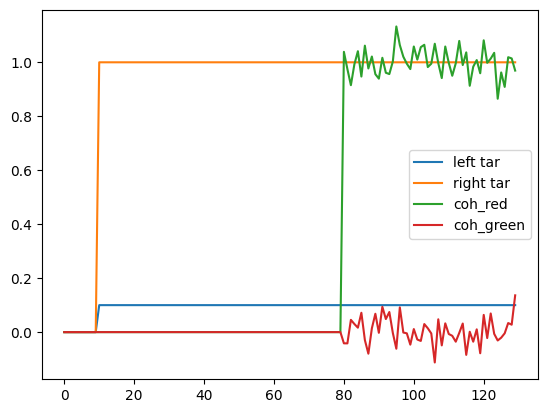

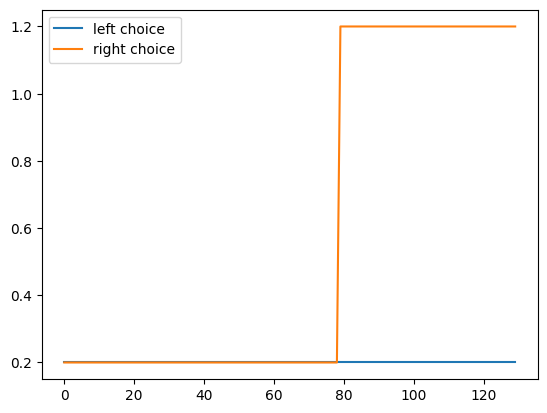

In [3]:
# plot some trials
# input: dim1: left target; dim2: right target; dim3: color coh
# red: 1; green: -1
# output dim1: left decision; dim2: right decision

id = 15

plt.figure()

plt.plot(u[id,:,0], label = 'left tar')
plt.plot(u[id,:,1], label = 'right tar')
plt.plot(u[id,:,2], label = 'coh_red')
plt.plot(u[id,:,3], label = 'coh_green')

plt.legend()

plt.figure()
plt.plot(z[id,:,0], label = 'left choice')
plt.plot(z[id,:,1], label = 'right choice')
plt.legend()



print(conditions[id])

#### Initialize and fit RNN model with 50 units and Dales Law constraint.

In [4]:
net = Net(n=50, input_size=u.shape[2], dale=True, sigma_rec=0.15)

# check initialization
# use gradient clipping


<Axes: >

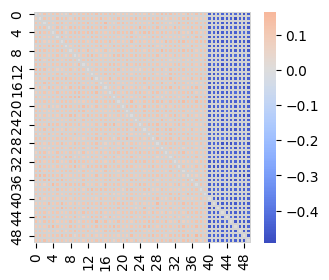

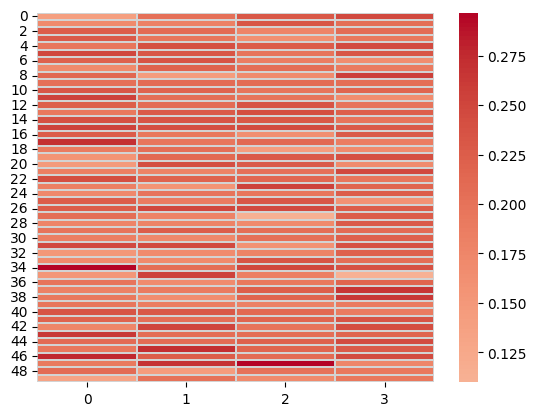

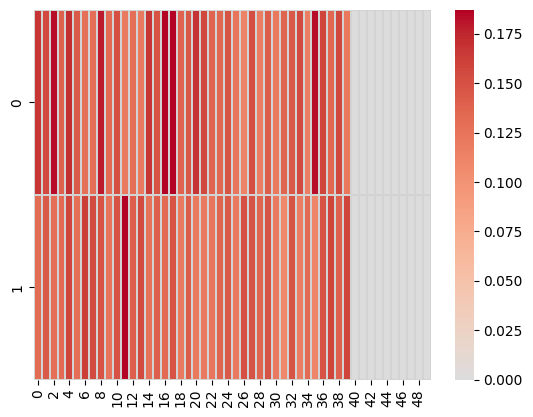

In [5]:
plt.figure(figsize=(3.5,3))
sns.heatmap( net.recurrent_layer.weight.data.detach().numpy(),center=0,cmap='coolwarm',linewidths=.1,linecolor='lightgray')

plt.figure()
sns.heatmap( net.input_layer.weight.data.detach().numpy(),center=0,cmap='coolwarm',linewidths=.1,linecolor='lightgray')

plt.figure()
sns.heatmap(net.output_layer.weight.data.detach().numpy(),center=0,cmap='coolwarm',linewidths=.1,linecolor='lightgray')


# # plot mask

# plt.figure(figsize=(3.5,3))
# sns.heatmap( net.dale_mask.detach().numpy(),center=0,cmap='coolwarm',linewidths=.1,linecolor='lightgray')

# plt.figure(figsize=(3.5,3))
# sns.heatmap( net.input_mask.detach().numpy(),center=0,cmap='coolwarm',linewidths=.1,linecolor='lightgray')

# plt.figure(figsize=(3.5,3))
# sns.heatmap( net.output_mask.detach().numpy(),center=0,cmap='coolwarm',linewidths=.1,linecolor='lightgray')


In [6]:
c = net.recurrent_layer.weight.data.detach().numpy()
np.sum(c)

0.21393955

In [10]:
c = net.recurrent_layer.weight.data.detach().numpy()
np.sum(c < 0)

1980

In [7]:
c = net.dale_mask.detach().numpy()
np.sum(c < 0)

1223

In [8]:
# train the network
net.fit(u, z, mask, lr=.01,
        epochs=50, 
        verbose=True, 
        weight_decay=0.001)
# Note: Due to random initialization of network parameters, not every run will result in a successful network.

Epoch: 5/50............. mse_z: 0.3185
Epoch: 10/50............. mse_z: 0.1467
Epoch: 15/50............. mse_z: 0.0856
Epoch: 20/50............. mse_z: 0.0614
Epoch: 25/50............. mse_z: 0.0518
Epoch: 30/50............. mse_z: 0.0408
Epoch: 35/50............. mse_z: 0.0373
Epoch: 40/50............. mse_z: 0.0370
Epoch: 45/50............. mse_z: 0.0320
Epoch: 50/50............. mse_z: 0.0307


In [9]:
# get RNN activities
x = net.forward(u)
output = net.output_layer(x)

output = output.cpu().detach().numpy()
x = x.cpu().detach().numpy()


In [10]:
# calculate accuracy

y = z.cpu().detach().numpy()

realO = output[:,80:,0] - output[:,80:,1]
tarO = y[:,80:,0] - y[:,80:,1]

a = np.sum(realO, axis = 1)
b = np.sum(tarO, axis = 1)

c = (a*b>0)*1

acc = np.sum(c)/y.shape[0]
print('accuracy is ', acc)


accuracy is  0.9709090909090909


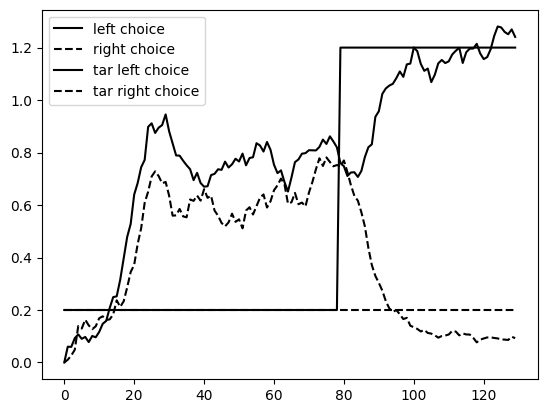

{'color_coh': -0.25, 'cxt': 1, 'correct_choice': -1}


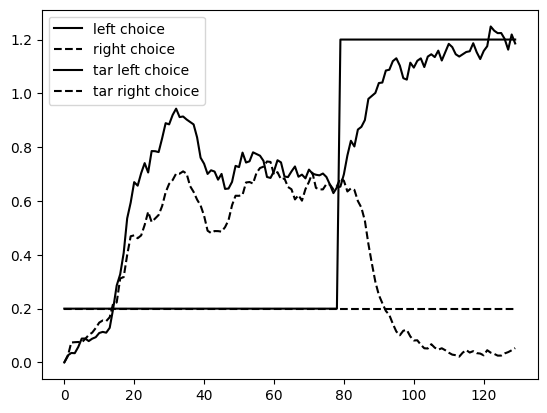

{'color_coh': -0.5, 'cxt': 1, 'correct_choice': -1}


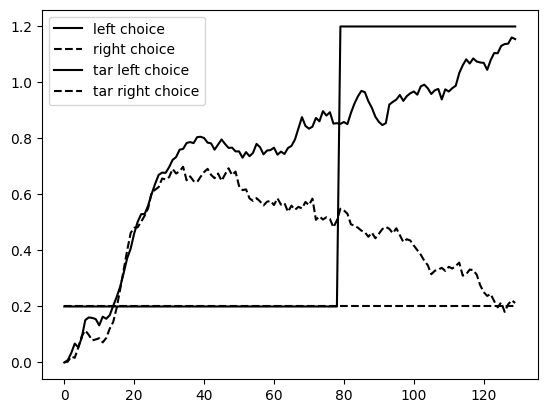

{'color_coh': 0.125, 'cxt': 0, 'correct_choice': -1}


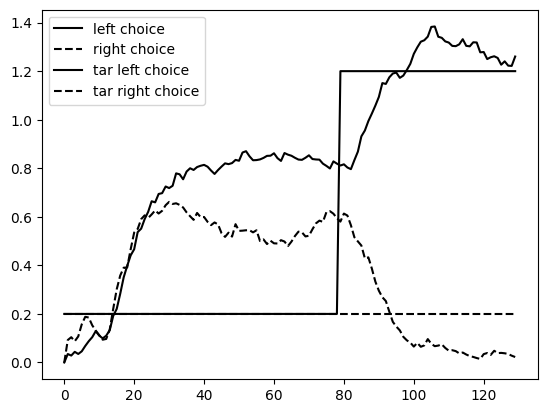

{'color_coh': 0.5, 'cxt': 0, 'correct_choice': -1}


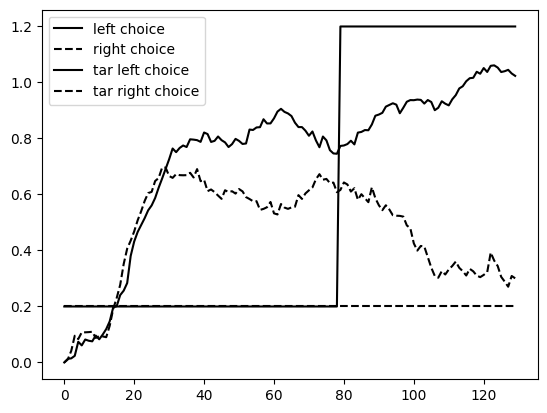

{'color_coh': 0.125, 'cxt': 0, 'correct_choice': -1}


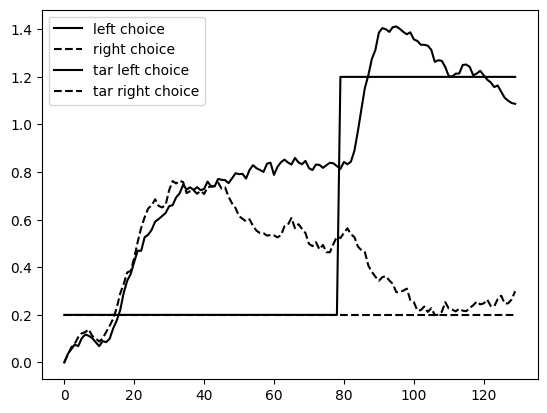

{'color_coh': 1.0, 'cxt': 0, 'correct_choice': -1}


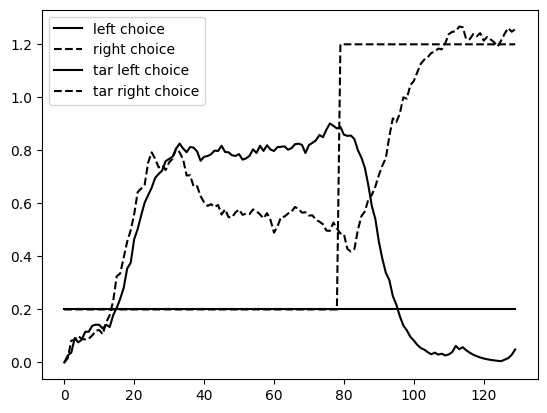

{'color_coh': -0.5, 'cxt': 0, 'correct_choice': 1}


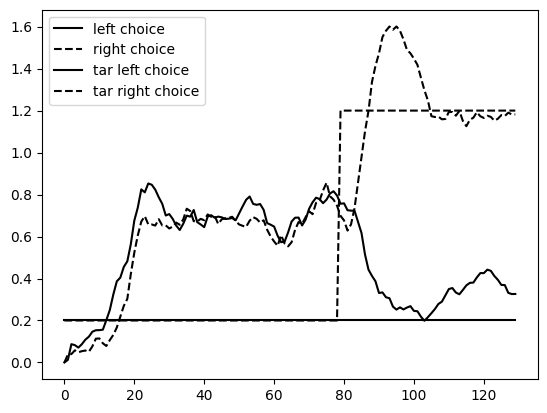

{'color_coh': 1.0, 'cxt': 1, 'correct_choice': 1}


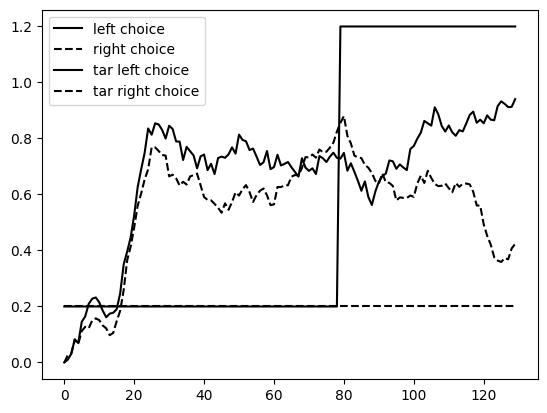

{'color_coh': -0.0625, 'cxt': 1, 'correct_choice': -1}


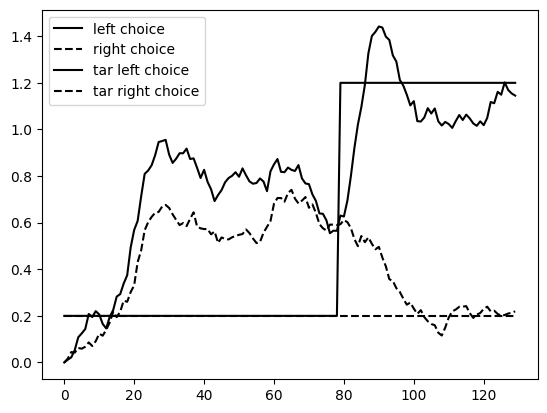

{'color_coh': -1.75, 'cxt': 1, 'correct_choice': -1}


In [11]:
# plot some results 
for id in range(10):
    plt.figure()
    plt.plot(output[id,:,0], 'k-',  label = 'left choice')
    plt.plot(output[id,:,1], 'k--', label = 'right choice')
    
    plt.plot(z[id,:,0], 'k-', label = 'tar left choice')
    plt.plot(z[id,:,1], 'k--', label = 'tar right choice') 
    plt.legend()
    plt.show()
    print(conditions[id])

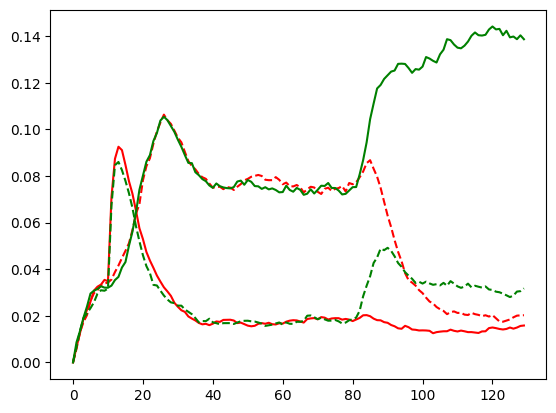

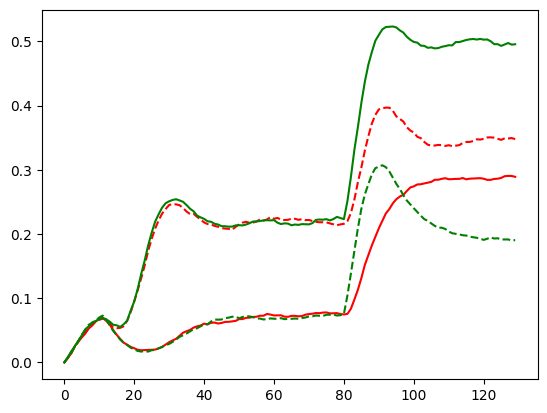

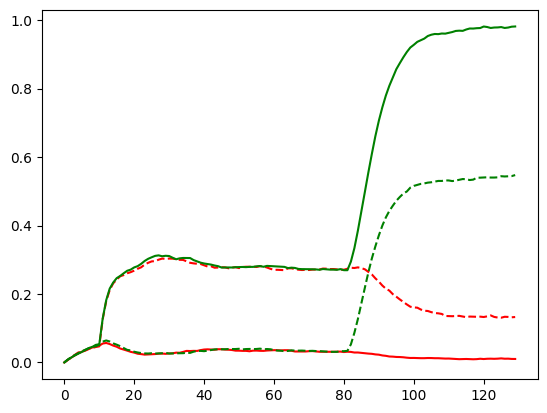

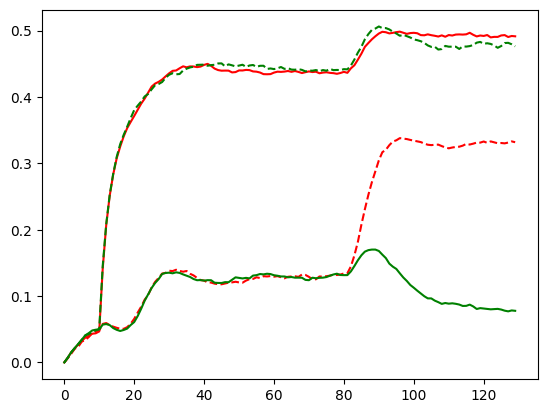

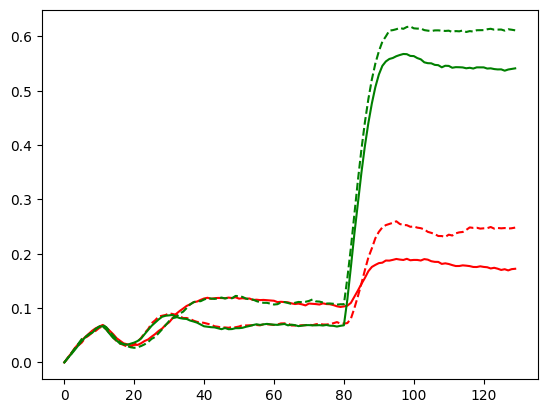

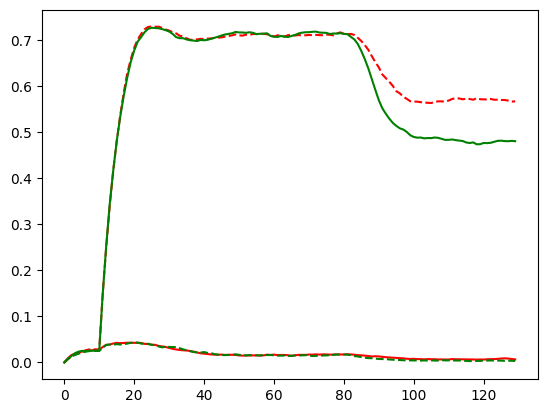

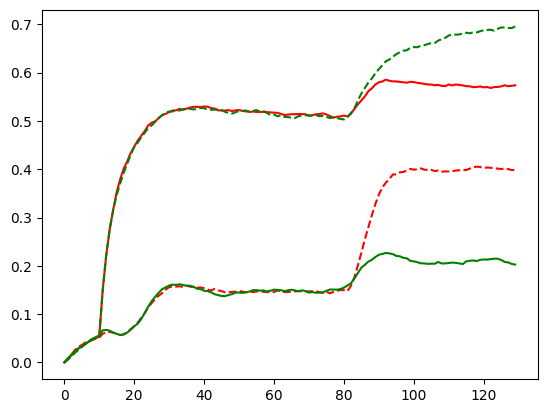

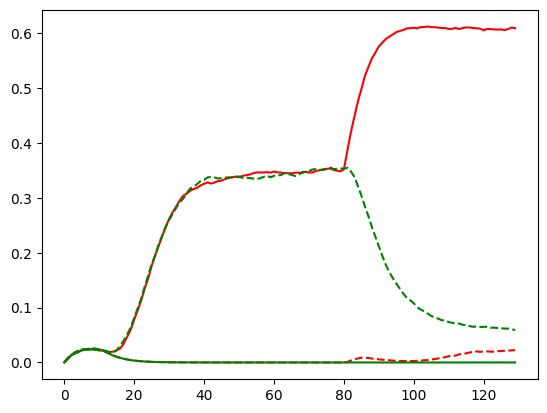

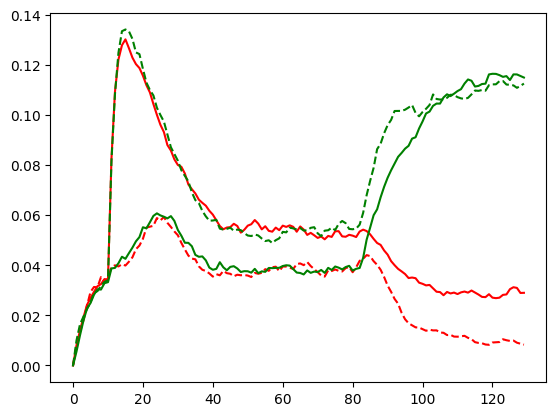

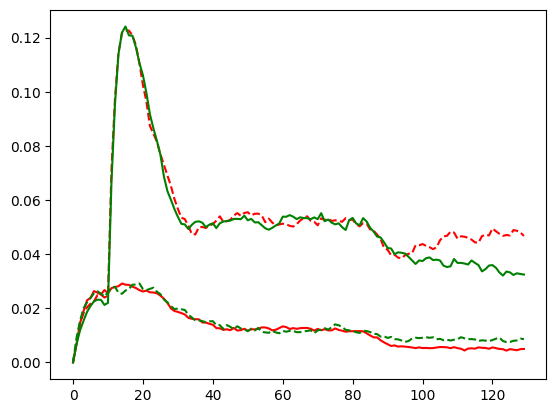

In [12]:
# plot psths 
coh = np.array([item['color_coh'] for item in conditions])
choice = np.array([item['correct_choice'] for item in conditions])

RL = (choice == -1) & (coh > 0)
RR = (choice == 1) & (coh > 0)
GL = (choice == -1) & (coh < 0)
GR = (choice == 1) & (coh < 0)


for id in range(40,50):
    plt.figure()
    
    plt.plot(np.mean(x[RL,:,id],axis=0), 'r-')
    plt.plot(np.mean(x[RR,:,id],axis=0), 'r--')
    plt.plot(np.mean(x[GL,:,id],axis=0), 'g-')
    plt.plot(np.mean(x[GR,:,id],axis=0), 'g--')
    plt.show()

#### Visualize connectivity parameters of RNN after training

<Axes: >

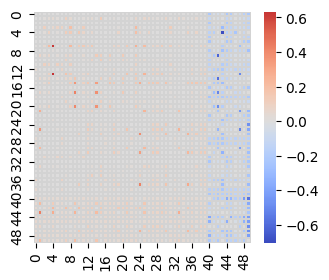

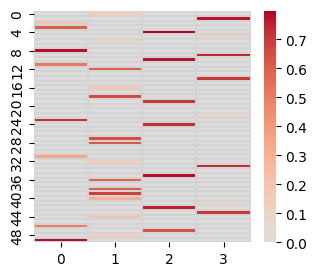

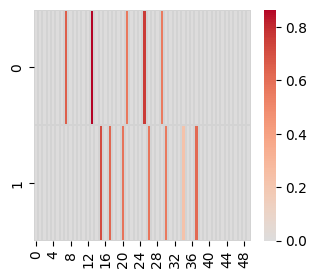

In [13]:
plt.figure(figsize=(3.5,3))
sns.heatmap( net.recurrent_layer.weight.data.detach().numpy(),center=0,cmap='coolwarm',linewidths=.1,linecolor='lightgray')
plt.figure(figsize=(3.5,3))
sns.heatmap( net.input_layer.weight.data.detach().numpy(),center=0,cmap='coolwarm',linewidths=.1,linecolor='lightgray')
plt.figure(figsize=(3.5,3))
sns.heatmap( net.output_layer.weight.data.detach().numpy(),center=0,cmap='coolwarm',linewidths=.1,linecolor='lightgray')

In [38]:
win = net.input_layer.weight.data.detach().numpy()

wout = net.output_layer.weight.data.detach().numpy()


In [13]:
# np.concatenate([win, wout.transpose()], axis = 1)


# Plot psychometric functions for trained RNN

In [9]:

u, z, mask, conditions  = generate_trials(n_trials=25)
df = psychometric(net,u,conditions)

KeyError: 'context'

## Fit latent circuit model to trained RNN

#### Initialize and fit latent circuit model

In [14]:
# Initialize
latent_net = LatentNet(n=6, N=net.n ,input_size=u.shape[2], n_trials = u.shape[0],sigma_rec = 0.15)

# Generate inputs to simulate RNN
# u, _, _, _  = generate_trials( n_trials=25,
#                                                 alpha=float(0.2),
#                                                 sigma_in=0.01,
#                                                 baseline=.2,
#                                                 n_coh=6)

u, _, _, _  = generate_trials(n_trials=50, noise_factor = 0.1)


# Simulate RNN
y = net(u)
z = net.output_layer(y)
# Fit latent circuit model
loss_history = latent_net.fit(u.detach(),z.detach(),y.detach(),epochs = 300,lr = .02,l_y = 1,weight_decay = 0.001)

Epoch: 0/300............. mse_z: 0.2257 nmse_y: 1.0324
Epoch: 10/300............. mse_z: 0.1295 nmse_y: 0.1340
Epoch: 20/300............. mse_z: 0.0781 nmse_y: 0.0666
Epoch: 30/300............. mse_z: 0.0523 nmse_y: 0.0625
Epoch: 40/300............. mse_z: 0.0393 nmse_y: 0.0594
Epoch: 50/300............. mse_z: 0.0294 nmse_y: 0.0520
Epoch: 60/300............. mse_z: 0.0248 nmse_y: 0.0451
Epoch: 70/300............. mse_z: 0.0247 nmse_y: 0.0459
Epoch: 80/300............. mse_z: 0.0232 nmse_y: 0.0433
Epoch: 90/300............. mse_z: 0.0225 nmse_y: 0.0424
Epoch: 100/300............. mse_z: 0.0224 nmse_y: 0.0429
Epoch: 110/300............. mse_z: 0.0219 nmse_y: 0.0417
Epoch: 120/300............. mse_z: 0.0215 nmse_y: 0.0424
Epoch: 130/300............. mse_z: 0.0216 nmse_y: 0.0413
Epoch: 140/300............. mse_z: 0.0216 nmse_y: 0.0414
Epoch: 150/300............. mse_z: 0.0214 nmse_y: 0.0416
Epoch: 160/300............. mse_z: 0.0210 nmse_y: 0.0425
Epoch: 170/300............. mse_z: 0.0212 

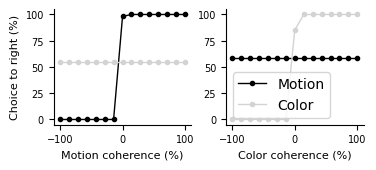

In [7]:
# Plot psychometric functions
u, z, mask, conditions  = generate_trials( n_trials=25,
                                                alpha=float(0.2),
                                                sigma_in=0.01,
                                                baseline=.2,
                                                n_coh=15)
df = psychometric(latent_net,u,conditions)

In [15]:
# get RNN activities
x = latent_net.forward(u)
output = latent_net.output_layer(x)

output = output.cpu().detach().numpy()
x = x.cpu().detach().numpy()



# calculate accuracy

y = z.cpu().detach().numpy()

realO = output[:,80:,0] - output[:,80:,1]
tarO = y[:,80:,0] - y[:,80:,1]

a = np.sum(realO, axis = 1)
b = np.sum(tarO, axis = 1)

c = (a*b>0)*1

acc = np.sum(c)/y.shape[0]
print('accuracy is ', acc)

accuracy is  0.9727272727272728


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

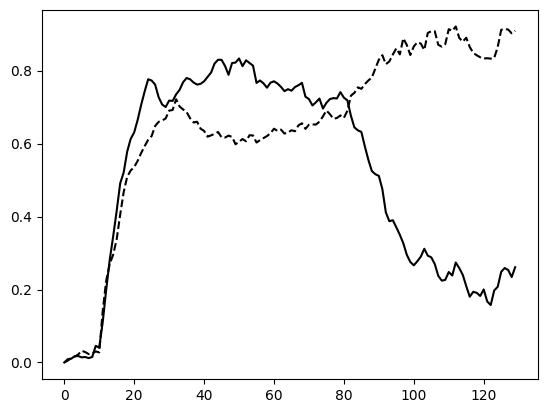

In [16]:
# plot some results 
for id in range(10):
    plt.figure()
    plt.plot(output[id,:,0], 'k-',  label = 'left choice')
    plt.plot(output[id,:,1], 'k--', label = 'right choice')
    
    plt.plot(z[id,:,0], 'k-', label = 'tar left choice')
    plt.plot(z[id,:,1], 'k--', label = 'tar right choice') 
    plt.legend()
    plt.show()
    print(conditions[id])

<Axes: >

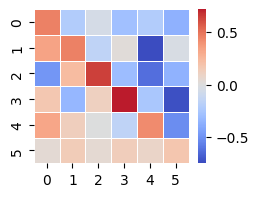

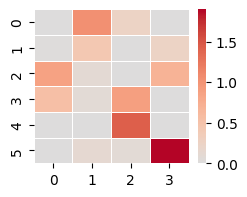

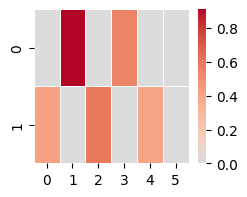

In [17]:
plt.figure(figsize=(2.5,2))
w_rec  = latent_net.recurrent_layer.weight.data.detach()
sns.heatmap(w_rec,center=0,cmap='coolwarm',linewidths=.5)

plt.figure(figsize=(2.5,2))
w_rec  = latent_net.input_layer.weight.data.detach()
sns.heatmap(w_rec,center=0,cmap='coolwarm',linewidths=.5)

plt.figure(figsize=(2.5,2))
w_rec  = latent_net.output_layer.weight.data.detach()
sns.heatmap(w_rec,center=0,cmap='coolwarm',linewidths=.5)

## Assessing fit quality of latent circuit model
There are several ways to assess the quality of fit of the latent circuit model.
1) Agreement between $Qx$ and $y$ where $x$ is the responses of the latent model, $y$ is the responses of the RNN and $Q$ is the orthonormal matrix that maps $x$ onto $y$.
2) Agreement between $x$ and $Q^Ty$ i.e. agreement in the subspace spanned by the columns of $Q$.
3) Agreement between $w_{rec}$ and $Q^TW_{rec}Q$.

#### 1) Agreement between $Qx$ and $y$

(-0.4119325429201126, 2.657401442527771)

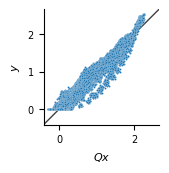

In [18]:


u, z, mask, conditions  = generate_trials(n_trials=50, noise_factor = 0.1)


y  = net(u).detach()
qx = latent_net(u)@latent_net.q
fig = plt.figure(figsize=(1.5,1.5))
gs = gridspec.GridSpec(1,1)
ax=fig.add_subplot(gs[0,0])
sns.scatterplot(x =qx.detach().flatten(),y = y.flatten(),ax=ax,s=2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("", fontsize=8)
ax.xaxis.set_tick_params(labelsize=7,bottom=True)
ax.yaxis.set_tick_params(labelsize=7,left=True)
ax.set_xlabel(r"$Qx$", fontsize=8)
ax.set_ylabel(r"$y$", fontsize=8)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0,lw=1)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

#### 2) Agreement between $x$ and $Q^Ty$

(-0.49240168184041977, 4.8340589046478275)

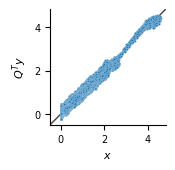

In [19]:
u, _, _, _  = generate_trials(n_trials=50, noise_factor = 0.1)


qty  = net(u).detach()@latent_net.q.t()
x = latent_net(u)
fig = plt.figure(figsize=(1.5,1.5))
gs = gridspec.GridSpec(1,1)
ax=fig.add_subplot(gs[0,0])
sns.scatterplot(x =x.detach().flatten(),y = qty.detach().flatten(),ax=ax,s=2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("", fontsize=8)
ax.xaxis.set_tick_params(labelsize=7,bottom=True)
ax.yaxis.set_tick_params(labelsize=7,left=True)
ax.set_xlabel(r"$x$", fontsize=8)
ax.set_ylabel(r"$Q^Ty$", fontsize=8)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0,lw=1)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

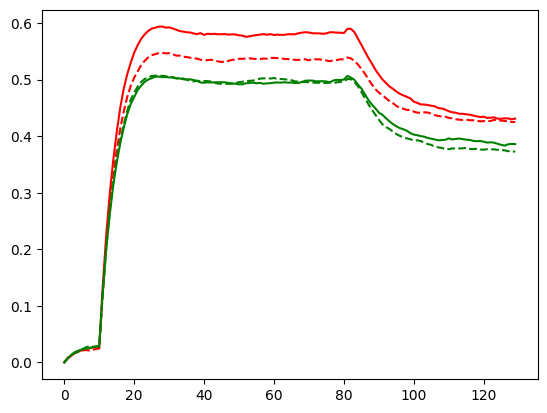

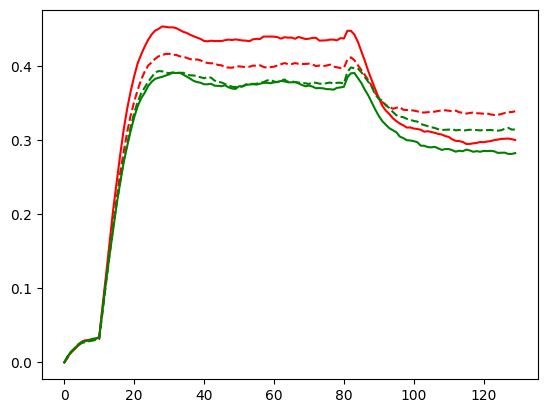

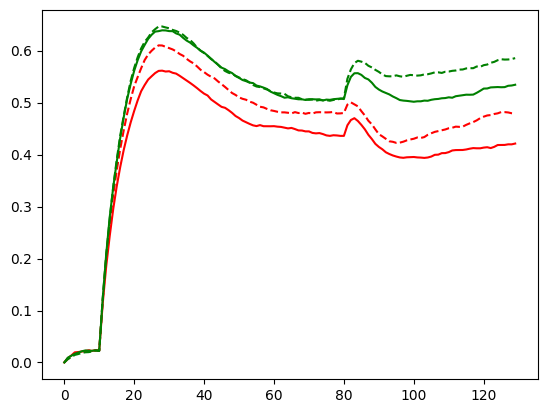

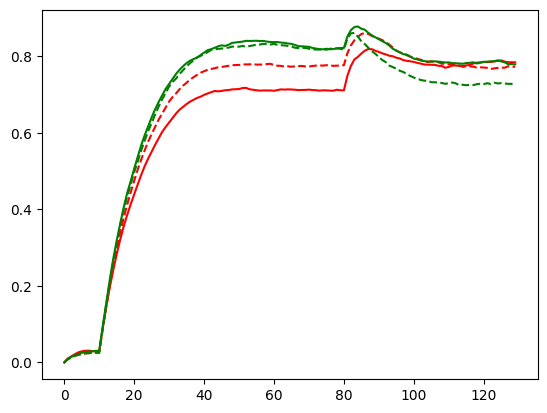

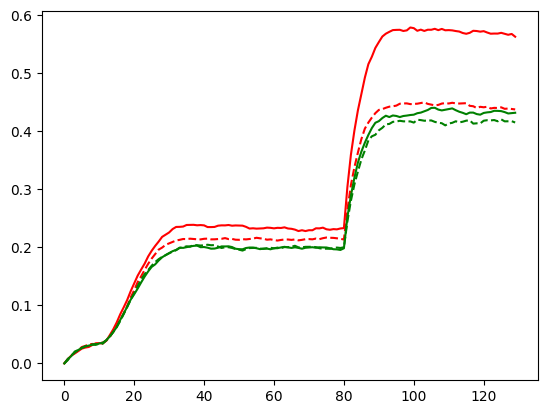

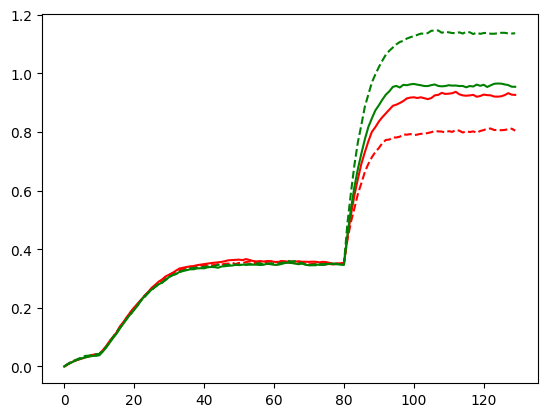

In [20]:
# plot latent variable x 
coh = np.array([item['color_coh'] for item in conditions])
choice = np.array([item['correct_choice'] for item in conditions])

xx = x.cpu().detach().numpy()


RL = (choice == -1) & (coh > 0)
RR = (choice == 1) & (coh > 0)
GL = (choice == -1) & (coh < 0)
GR = (choice == 1) & (coh < 0)


for id in range(6):
    plt.figure()
    
    plt.plot(np.mean(xx[RL,:,id],axis=0), 'r-')
    plt.plot(np.mean(xx[RR,:,id],axis=0), 'r--')
    plt.plot(np.mean(xx[GL,:,id],axis=0), 'g-')
    plt.plot(np.mean(xx[GR,:,id],axis=0), 'g--')
    plt.show()


# plt.figure()

# plt.plot(np.mean(x[RL,:,pair[1]],axis=0) - np.mean(x[RL,:,pair[0]],axis=0), 'r-')
# plt.plot(np.mean(x[RR,:,pair[1]],axis=0) - np.mean(x[RL,:,pair[0]],axis=0), 'r--')
# plt.plot(np.mean(x[GL,:,pair[1]],axis=0) - np.mean(x[RL,:,pair[0]],axis=0), 'g-')
# plt.plot(np.mean(x[GR,:,pair[1]],axis=0) - np.mean(x[RL,:,pair[0]],axis=0), 'g--')
# plt.show()

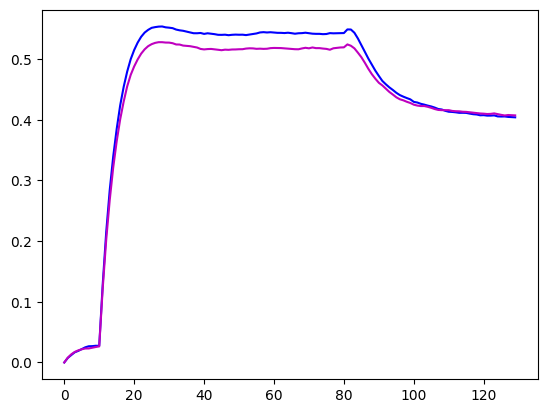

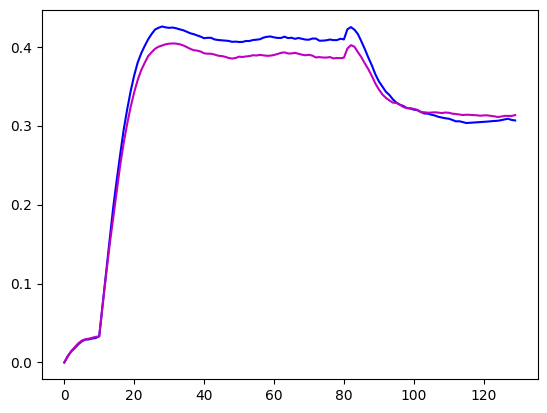

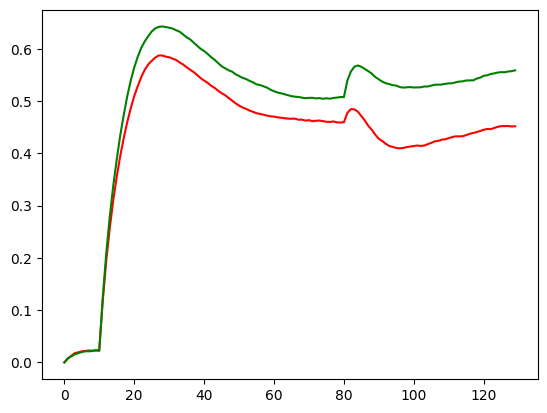

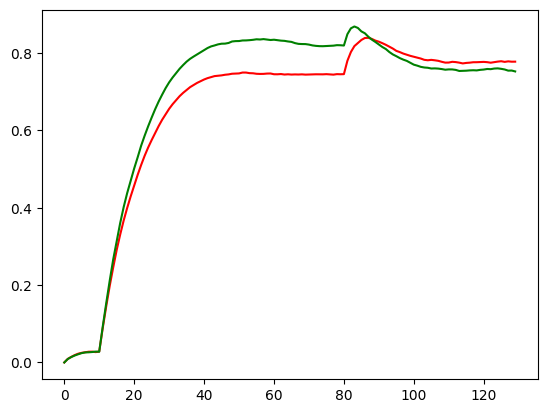

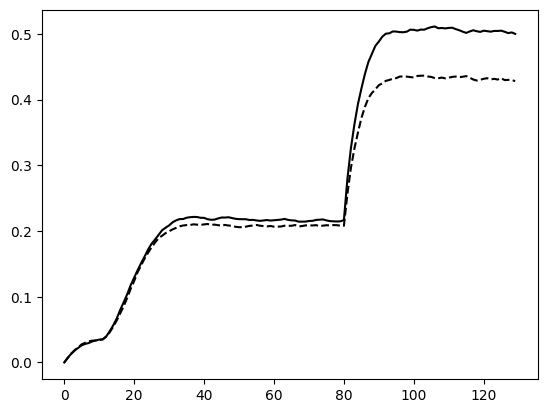

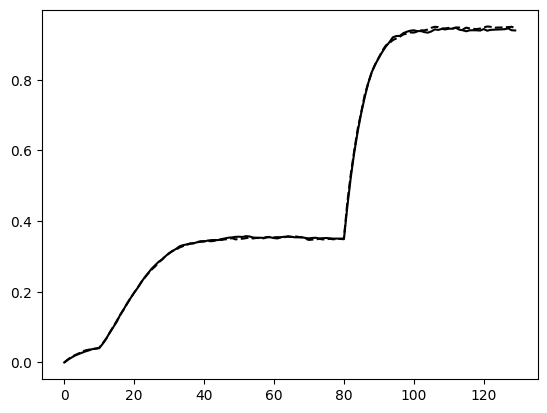

In [21]:
# plot latent variable x 
coh = np.array([item['color_coh'] for item in conditions])
choice = np.array([item['correct_choice'] for item in conditions])

xx = x.cpu().detach().numpy()


red = (coh > 0)
green = (coh < 0)
left = (choice == -1)
right = (choice == 1)

cxt1 = (red & left) | (green & right)
cxt2 = (red & right) | (green & left)

plt.figure()
plt.plot(np.mean(xx[cxt1,:,0],axis=0), 'b-')
plt.plot(np.mean(xx[cxt2,:,0],axis=0), 'm-')
plt.show()

plt.figure()
plt.plot(np.mean(xx[cxt1,:,1],axis=0), 'b-')
plt.plot(np.mean(xx[cxt2,:,1],axis=0), 'm-')
plt.show()

plt.figure()
plt.plot(np.mean(xx[red,:,2],axis=0), 'r-')
plt.plot(np.mean(xx[green,:,2],axis=0), 'g-')
plt.show()

plt.figure()
plt.plot(np.mean(xx[red,:,3],axis=0), 'r-')
plt.plot(np.mean(xx[green,:,3],axis=0), 'g-')
plt.show()

plt.figure()
plt.plot(np.mean(xx[left,:,4],axis=0), 'k-')
plt.plot(np.mean(xx[right,:,4],axis=0), 'k--')
plt.show()

plt.figure()
plt.plot(np.mean(xx[left,:,5],axis=0), 'k-')
plt.plot(np.mean(xx[right,:,5],axis=0), 'k--')
plt.show()

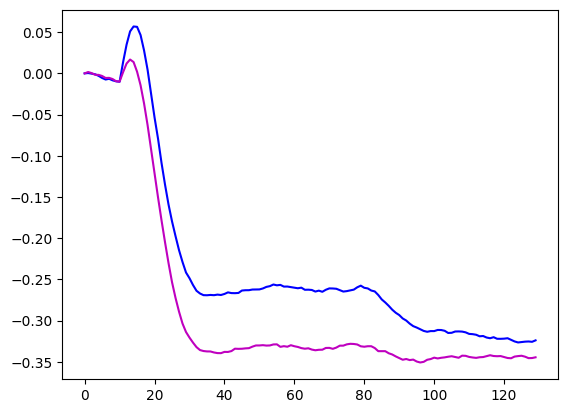

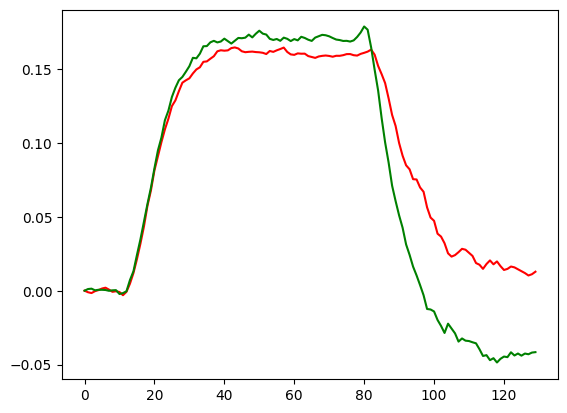

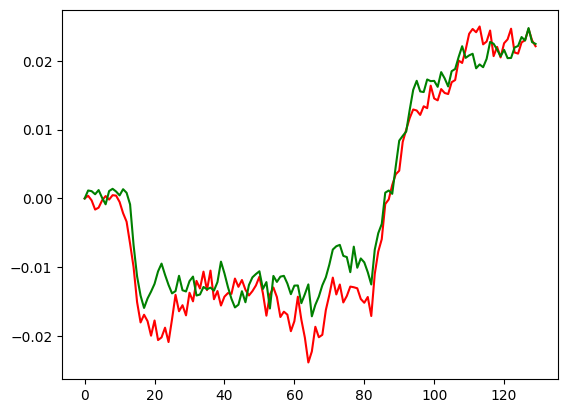

In [28]:
pair = [0, 1]
plt.figure()
plt.plot(np.mean(xx[cxt1,:,pair[1]],axis=0) - np.mean(xx[cxt1,:,pair[0]],axis=0), 'b-')
plt.plot(np.mean(xx[cxt2,:,pair[1]],axis=0) - np.mean(xx[cxt2,:,pair[0]],axis=0), 'm-')
plt.show()

pair = [2,3]
plt.figure()
plt.plot(np.mean(xx[red,:,pair[1]],axis=0) - np.mean(xx[red,:,pair[0]],axis=0), 'r-')
plt.plot(np.mean(xx[green,:,pair[1]],axis=0) - np.mean(xx[green,:,pair[0]],axis=0), 'g-')
plt.show()

pair = [6,7]
plt.figure()
plt.plot(np.mean(xx[left,:,pair[1]],axis=0) - np.mean(xx[left,:,pair[0]],axis=0), 'r-')
plt.plot(np.mean(xx[right,:,pair[1]],axis=0) - np.mean(xx[right,:,pair[0]],axis=0), 'g-')
plt.show()

#### 3) Agreement between $w_{rec}$ and $Q^TW_{rec}Q$

Text(0.5, 1.0, '$Q^Tw_{rec}Q$')

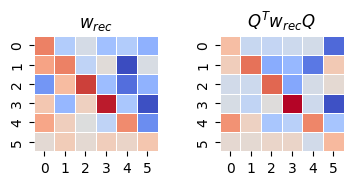

In [22]:
w_rec = latent_net.recurrent_layer.weight.data.detach()
q = latent_net.q.detach()
W_rec = net.recurrent_layer.weight.data.detach()

# Plot
fig = plt.figure(figsize=(4,1.5))
gs = gridspec.GridSpec(1,2,wspace = .5)
ax0=fig.add_subplot(gs[0,0])
ax1=fig.add_subplot(gs[0,1])

sns.heatmap(w_rec, ax=ax0, cmap='coolwarm',center=0,cbar=False,lw=.5)
ax0.set_title(r"$w_{rec}$")
sns.heatmap(q@W_rec@q.T, ax=ax1, cmap='coolwarm',center=0,cbar=False,lw=.5)
ax1.set_title(r"$Q^Tw_{rec}Q$")